In [771]:
%pylab inline
import mne
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/usr/local/Cellar/jupyter/1.0.0_5/libexec/vendor/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Opening raw data file /Users/dkristensen/Documents/Masters Program/IFT 6269 - Probabilistic Graphical Models/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.


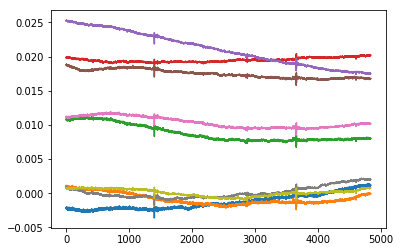

In [772]:
filename = "P01-raw.fif"
raw = mne.io.read_raw_fif(filename)

sfreq = raw.info['sfreq']

block_data,times = raw[:9,:]
block_data = block_data.T

plot(times,block_data)
show()

In [773]:
# Number of iterations in Kalman Filter
N_iter = int(6*sfreq)
start_second = 1
end_second = 3


In [774]:
def normal_prob(x,mu,sigma):
    front = 1/(2*np.pi*np.sqrt(np.linalg.det(sigma)))
    exponent = np.matmul((x-mu),np.matmul(np.linalg.inv(sigma),(x-mu)).T)
    return front * math.e**(-1/2 * exponent)[0]


def predict(state_estimate, state_cov, transition_matrix, noise_cov, control_mat, control_vec):
    if(len(state_estimate.shape) is 1):    
        state_estimate = state_estimate.reshape(state_estimate.shape[0],1)
    state_estimate = np.matmul(transition_matrix, state_estimate) + np.matmul(control_mat, control_vec)
    state_cov = np.matmul(transition_matrix, np.matmul(state_cov, transition_matrix.T)) + noise_cov
    return state_estimate,state_cov 


#observation data is z_k
#Observation matrix is H_k
#State estimate is x_k
#State cov is P_k
#Observation noise is R_k
def update(state_estimate, state_covariance, observation_data, observation_covariance,observation_noise):
    innovation_prefit = observation_data - np.matmul(observation_covariance,state_estimate) 
    innovation_covariance = observation_noise + np.matmul(observation_covariance,np.matmul(state_covariance,observation_covariance.T))
    
    Kalman_gain = np.matmul(state_covariance,np.matmul(observation_covariance.T,np.linalg.inv(innovation_covariance)))
    updated_state_estimate = state_estimate+np.matmul(Kalman_gain,innovation_prefit)
    state_cov_helper = np.identity(Kalman_gain.shape[0])-np.matmul(Kalman_gain,observation_covariance)
    updated_state_covariance = np.matmul(state_cov_helper,np.matmul(state_covariance,state_cov_helper.T)) + np.matmul(Kalman_gain,np.matmul(observation_noise,Kalman_gain.T))
    
    innovation_postfit = observation_data - np.matmul(observation_covariance,updated_state_estimate)
    return updated_state_estimate,updated_state_covariance,innovation_prefit,innovation_postfit

done


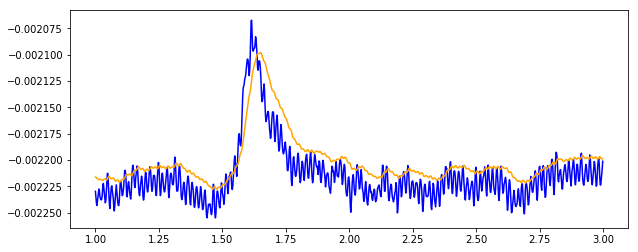

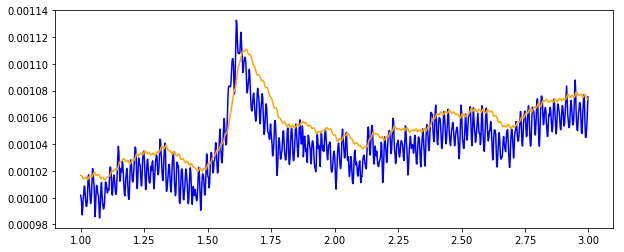

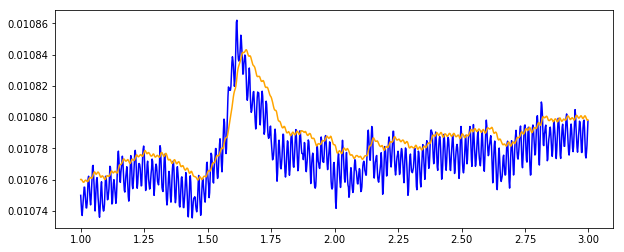

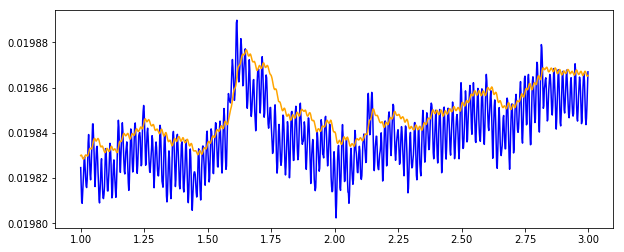

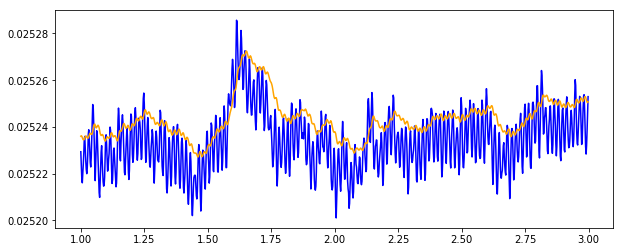

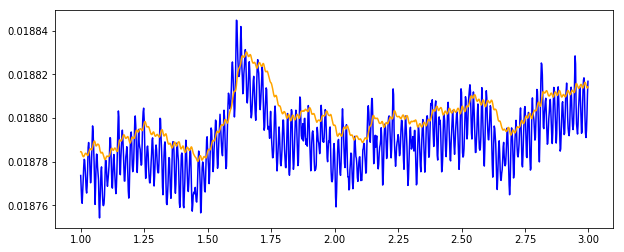

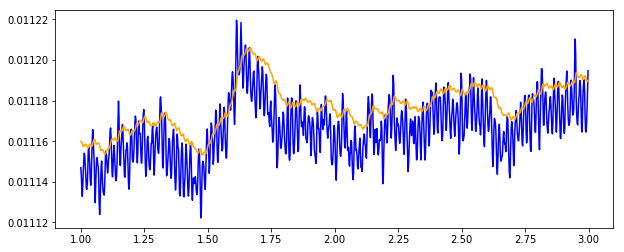

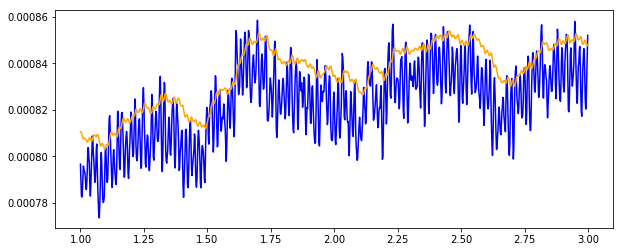

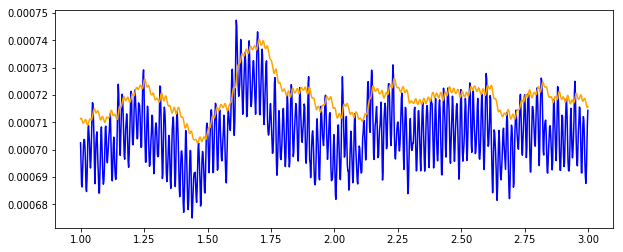

In [770]:
n_features = block_data.shape[1]

#time step of mobile movement
dt = 1/(1*sfreq)

# Initialization of state matrices
state_estimate = np.ones(n_features)*0.001#block_data[0,:]
state_cov = np.diag([0.005]*n_features)

transition_matrix = np.eye(n_features)+(np.ones(shape=(n_features,n_features))-np.eye(n_features))*0.00001
# for i in range(n_features-1):
#     transition_matrix[i,(i+2)%n_features] = dt
    
noise_cov = np.eye(state_estimate.shape[0])/(sfreq*0.5)

control_model = np.eye(state_estimate.shape[0])
control_vec = np.zeros((state_estimate.shape[0],1))



# Measurement matrices
observed_value = state_estimate.reshape(n_features,1)
observation_model = np.eye(n_features)

observation_cov = np.eye(observed_value.shape[0])


prediction ,measurements = [],[]

# Applying the Kalman Filter
for i in np.arange(N_iter):
    state_estimate, state_cov = predict(state_estimate, state_cov, transition_matrix, noise_cov, control_model, control_vec)
    
    state_estimate, state_cov, pre,post = update(state_estimate, state_cov, observed_value, observation_model, observation_cov)

    prediction.append(state_estimate)


    observed_value = block_data[i].reshape(n_features,1)
    

prediction = np.array(prediction).reshape(N_iter,n_features)

start_index = int(start_second*sfreq)
end_index = int(end_second*sfreq)

for i in range(n_features):
    figure(figsize=(10,4))
    plot(np.arange(start_index,end_index)/sfreq,block_data[start_index:end_index,i], color = 'blue') 
    plot(np.arange(start_index,end_index)/sfreq,prediction[start_index:end_index,i],color='orange')
print("done")